In [1]:
import pickle
import os

FOLDER = os.getcwd() + "/5cell_test"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import math
import numpy as np
import random
import time



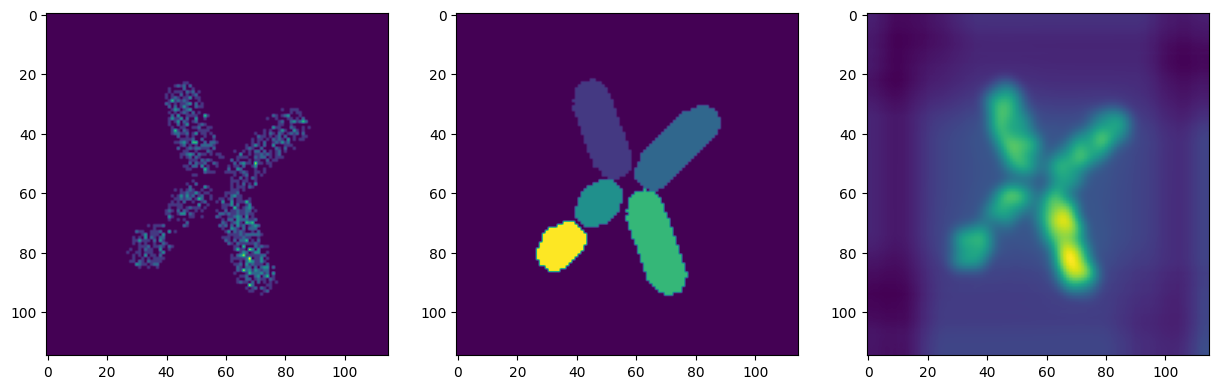

In [3]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

In [4]:
#Final all non zero mask points

sourcePts = []

(maskWidth, maskHeight) = mask.shape

for i in range(maskWidth):
    for j in range(maskHeight):
        if mask[i,j] != 0:
            sourcePts.append([i,j])
print(len(sourcePts))

#Take only a random subset of the sourcePts

random.shuffle(sourcePts)
sourcePts = sourcePts[:5000]

"""
for k in sourcePts:
    plt.scatter(k[1],k[0],c='r')
plt.imshow(mask)
"""


1681


"\nfor k in sourcePts:\n    plt.scatter(k[1],k[0],c='r')\nplt.imshow(mask)\n"

In [5]:
def AverageFilter(img, x, y):
    sz = [ -3, -2, -1, 0 , 1, 2, 3]
    total = 0
    for i in sz:
        for j in sz:
            total += img[x+i][y+j]
    total/=len(sz)*len(sz)
    return total

outputIntensity = {}
(outputWidth, outputHeight) = out.shape

for pt in sourcePts:
    x = pt[0]
    y = pt[1]
    outputIntensity[(x,y)] = AverageFilter(out,x,y)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
def euclideanDistance(x,y):
    return ((x[0]-y[0])**2 + (x[1]-y[1])**2)**0.5

N = len(sourcePts)
distanceMatrix= []
intensityMatrix = []
maskSize = euclideanDistance(mask.shape,(0,0)) 

for idx in range(N):
    current = sourcePts[idx]
    distance = [euclideanDistance(sourcePts[k],current)/maskSize for k in range(N)] #Normalise by diagonal length of mask
    intensty = [AverageFilter(out,current[0],current[1])/65535] #Normalise by max intensity
    distanceMatrix.append(torch.tensor(distance))
    intensityMatrix.append(torch.tensor(intensty))

#Convert to tensor
distanceMatrix = torch.stack(distanceMatrix)
intensityMatrix = torch.stack(intensityMatrix)

In [8]:
#Create custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, distanceMatrix, intensityMatrix):
        self.distanceMatrix = distanceMatrix
        self.intensityMatrix = intensityMatrix
    def __len__(self):
        return len(self.intensityMatrix)

    def __getitem__(self, idx):
        return (self.distanceMatrix[idx], self.intensityMatrix[idx]) 
dataset = CustomDataset(distanceMatrix, intensityMatrix)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

In [38]:
class Net(nn.Module):
    def __init__(self,N,output_intensity):
        super(Net, self).__init__()
        self.polynomial_degree = 7
        self.polynomial_weights = nn.Linear(self.polynomial_degree,1,bias=False)
        self.polynomial_weights.weight.data[0][0] = -150
        self.actual_intensity = nn.Linear(N,1,bias=False)
        for i in range(N):
            self.actual_intensity.weight.data[0][i] = output_intensity[i]
    def getPSF(self,x):
        stack = []
        for i in range (1, self.polynomial_degree+1):
            stack.append(torch.pow(x,2*i))
        x = torch.stack(stack, dim=2)
        x = self.polynomial_weights(x)
        x = x.reshape(x.shape[0],x.shape[1])
        x = torch.exp(x)
        return x
        
    def forward(self, x):
        x = self.getPSF(x)
        x = self.actual_intensity(x)
        return x

model = Net(N,intensityMatrix.data.flatten())
model.actual_intensity.weight.data.clamp_(0, 1) #Clamp parameters of last layer
#model.polynomial_weights.bias.data.clamp_(1, 1) #Clamp parameters of const of polynomial

#Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD([
                    {'params': model.polynomial_weights.parameters(), 'lr': 0.1},
                    {'params': model.actual_intensity.parameters(), 'lr': 0.001}
                ], lr=0.001, momentum=0.9)


In [34]:
#Training loop

EPOCH = 100
timestr = time.strftime("%Y%m%d-%H%M%S")
PATH = FOLDER + "/model-"+timestr+".pt"


for epoch in range(EPOCH):  # loop over the dataset multiple times
    print("Epoch: ",epoch+1)
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        model.zero_grad()
        # get the inputs; data is a list of [inputs, labels]
        inputs, outputs = data
        # forward + backward + optimize
        nn_outputs = model(inputs)
        loss = criterion(nn_outputs.float(), outputs.float())
        loss.backward()
        optimizer.step()
        model.actual_intensity.weight.data.clamp_(0, 1) #Clamp parameters of last layer
        #model.polynomial_weights.bias.data.clamp_(1, 1) #Clamp parameters of const of polynomial
        # print statistics
        running_loss += loss.item()
    print("Loss: ",running_loss)
print('Finished Training')

LOSS = criterion(nn_outputs.float(), outputs.float())

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)


Epoch:  1
tensor([[0.0087, 0.1599, 0.0348,  ..., 0.1571, 0.1656, 0.0550],
        [0.1349, 0.0184, 0.1108,  ..., 0.2650, 0.2256, 0.1821],
        [0.2392, 0.3908, 0.2640,  ..., 0.1930, 0.2761, 0.2017],
        ...,
        [0.2724, 0.4235, 0.2974,  ..., 0.2255, 0.2967, 0.2362],
        [0.1740, 0.2088, 0.1817,  ..., 0.3219, 0.0389, 0.2221],
        [0.1268, 0.2781, 0.1497,  ..., 0.1061, 0.2202, 0.0836]])
tensor([[[7.5614e-05, 5.7175e-09, 4.3233e-13,  ..., 2.4718e-21,
          1.8691e-25, 1.4133e-29],
         [2.5558e-02, 6.5319e-04, 1.6694e-05,  ..., 1.0904e-08,
          2.7869e-10, 7.1227e-12],
         [1.2098e-03, 1.4637e-06, 1.7708e-09,  ..., 2.5919e-15,
          3.1358e-18, 3.7938e-21],
         ...,
         [2.4688e-02, 6.0950e-04, 1.5047e-05,  ..., 9.1714e-09,
          2.2643e-10, 5.5900e-12],
         [2.7410e-02, 7.5132e-04, 2.0594e-05,  ..., 1.5473e-08,
          4.2411e-10, 1.1625e-11],
         [3.0246e-03, 9.1481e-06, 2.7669e-08,  ..., 2.5312e-13,
          7.6557e-1

KeyboardInterrupt: 

[1.00000000e+00 9.84811962e-01 9.40617919e-01 8.71324301e-01
 7.82804072e-01 6.82076335e-01 5.76394200e-01 4.72403377e-01
 3.75502735e-01 2.89480954e-01 2.16438204e-01 1.56947613e-01
 1.10377960e-01 7.52865747e-02 4.98034991e-02 3.19528207e-02
 1.98822860e-02 1.19986199e-02 7.02268910e-03 3.98643082e-03
 2.19468866e-03 1.17184478e-03 6.06843329e-04 3.04783724e-04
 1.48462117e-04 7.01376339e-05 3.21362531e-05 1.42807221e-05
 6.15484487e-06 2.57273359e-06 1.04300148e-06 4.10098608e-07
 1.56388396e-07 5.78409214e-08 2.07483382e-08 7.21844762e-09
 2.43569298e-09 7.97116873e-10 2.53010168e-10 7.78887441e-11
 2.32559770e-11 6.73469093e-12 1.89157305e-12 5.15297928e-13
 1.36150788e-13 3.48908016e-14 8.67232735e-15 2.09070855e-15
 4.88865595e-16 1.10872841e-16 2.43894650e-17 5.20388216e-18
 1.07695038e-18 2.16179879e-19 4.20913472e-20 7.94926062e-21
 1.45623077e-21 2.58759706e-22 4.45999426e-23 7.45672506e-24
 1.20933008e-24 1.90251322e-25 2.90343153e-26 4.29821611e-27
 6.17266325e-28 8.599461

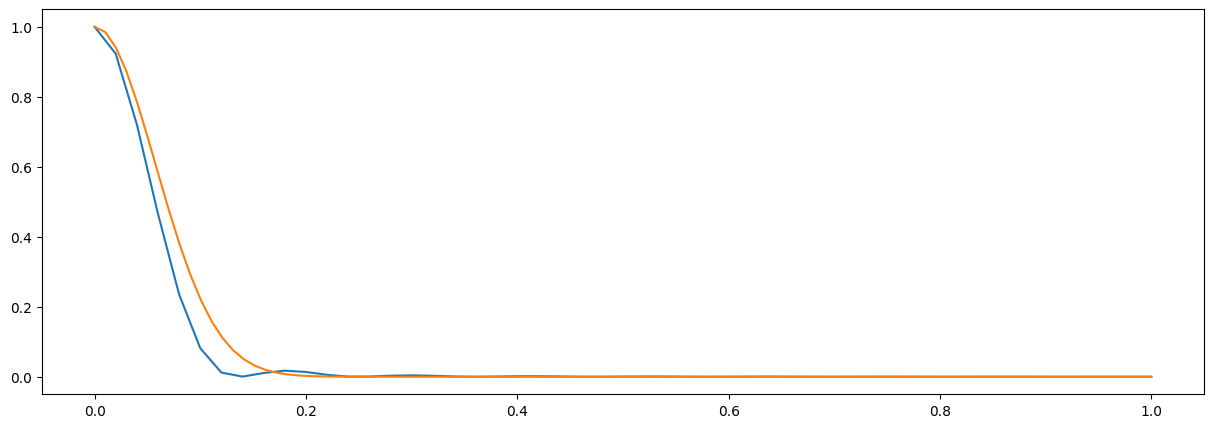

In [48]:
#Checks our model's psf against original psf

with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)

#Normalise x axis of original psf to 1
original_psf_x = np.linspace(0,1,len(original_psf))
original_psf_y = original_psf
plt.plot(original_psf_x,original_psf_y)

new_psf_x = [np.linspace(0,1,100,dtype=np.float32)]
new_psf_y = model.getPSF(torch.tensor(new_psf_x))
new_psf_x = new_psf_x[0]
new_psf_y = new_psf_y.detach().numpy().flatten()
plt.plot(new_psf_x,new_psf_y)
plt.show()


In [12]:
print(model.polynomial_weights.weight.data)
print(model.actual_intensity.weight.data)

tensor([[-5.4413e+02, -3.5986e+00,  8.2893e-02, -1.5741e-01,  3.1723e-01,
          1.1002e-01, -3.6196e-01]])
tensor([[0.0031, 0.0059, 0.0059,  ..., 0.0036, 0.0054, 0.0007]])


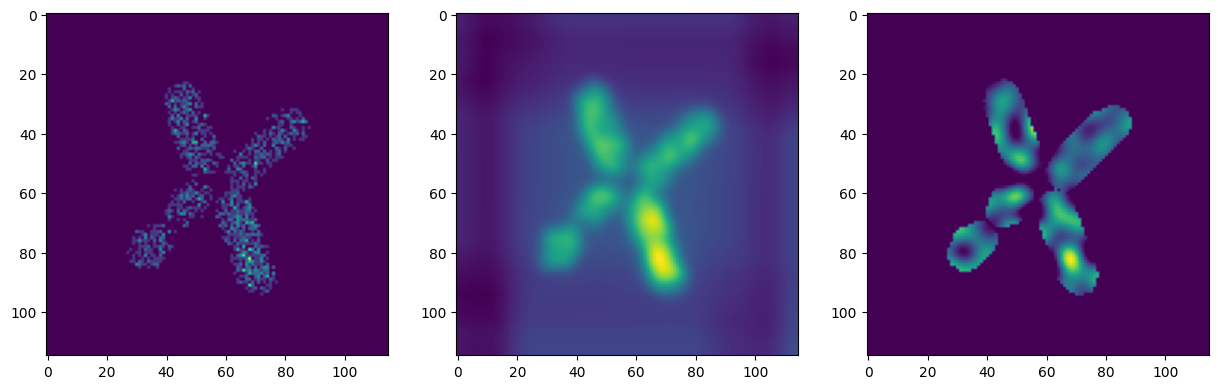

In [13]:
#Recreate original image based off of calculated intensity

customOriginal = np.zeros((maskWidth,maskHeight))
maskToNewIntensity = {}
maskToNewIntensity[0.0] = 0.0
modelIntensity = model.actual_intensity.weight.data[0]
for i in range(len(modelIntensity)):
    customOriginal[sourcePts[i][0]][sourcePts[i][1]] = modelIntensity[i]

oriNormalised = np.asanyarray(ori)
oriNormalised = oriNormalised / max(oriNormalised.flatten())

outNormalised = np.asanyarray(out)
outNormalised = outNormalised / max(outNormalised.flatten())

customOriginal = customOriginal / max(customOriginal.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(oriNormalised)
axarr[1].imshow(outNormalised)
axarr[2].imshow(customOriginal)
plt.show()
